# Tutorial 2 – Training Energies and Forces

To predict potential energy surfaces (PESs) for multiple electronic states, we include the energies and forces of the respective electronic states in the training.
The forces ($\mathbf{F}_i$) are of shape $N_{atoms} \times N_{states} \times 3$ and describe the cartesian force acting on each atom ($i$) due to the potential energy ($E$), which has a shape $1 \times N_{states}$. 
Thus, forces are defined as the negative gradient of the respective potential energy of each electronic state with respect to the nuclear position of each atom $\mathbf{R}_i$.

\begin{equation}
\displaystyle \mathbf{F}_i = - \frac{\partial E}{\partial \mathbf{R}_i}
\end{equation}

In the machine learning model, the forces are implemented accordingly, *i.e.*, by defining a model for energy and taking the respective derivative.

In the following we show how to train a model for a PES on energies and forces.

## Load and Preprocess Data

To process and prepare data for training, we begin with importing all relevant packages and specifying the location of an existing ASE (Atomic Simulation Envirnonment) database. Please return to the first tutorial to learn how to convert original quantum chemical data into an ASE database.

In [1]:
import sys, os

import torch
import torchmetrics
import pytorch_lightning as pl
import schnetpack as spk

import spainn

Initially, we establish the pathway for reaching the database that we intend to employ for training the neural network (NN). 
It is essential to ensure that `'_distance_unit'`, `'atomrefs'`, and `'_property_unit_dict'` are all retained within the metadata. 
You can verify this by referring to the provided example below:


In [2]:
from ase.db import connect
dbname = 'spainn_ch2nh2+.db'
datapath = os.path.join(os.getcwd(), 'data', dbname)
db = connect(datapath)

db.metadata

{'n_singlets': 3,
 'n_triplets': 0,
 'states': 'S S S ',
 'phasecorrected': False,
 'ReferenceMethod': 'MR-CISD(6,4)/aug-cc-pVDZ, program: COLUMBUS',
 'atomrefs': {},
 '_distance_unit': 'Bohr',
 '_property_unit_dict': {'energy': 'Hartree',
  'forces': 'Hartree/Bohr',
  'nacs': '1',
  'smooth_nacs': '1'}}

Next the data is loaded form the database `spainn_ch2nh2+.db` from the data folder, which contains among others the energies and forces of the three lowest singlet states, *i.e.*, $S_0$, $S_1$, and $S_2$ (`nstates=3`) of 99 displaced geometries of the methylenimmonium cation. 
For this we use the ``SPAINN`` class that inhertits the ``AtomsDataModule`` class provided by SchNetPack.

In [3]:
%rm ./train/split.npz

data_module = spainn.SPAINN(
    n_states = 3, # singlet states 0, 1, 2
    n_nacs = 3, # couplings: 01, 02, 12
    datapath=datapath, # path to database
    batch_size=2,
    num_train=0.7, # 70% of databse for training
    num_val=0.1, # 10% of database for validation
    split_file=os.path.join('train', 'split.npz'), # path to model (training folder)
    splitting=spk.data.splitting.RandomSplit(),
    load_properties=['energy', 'forces'],
    transforms=[
        # remove mean of energy in every electronic state
        spk.transform.RemoveOffsets(spainn.SPAINN.energy, remove_mean=True, remove_atomrefs=False),
        spk.transform.ASENeighborList(cutoff=5.0),
        spk.transform.CastTo32(),
            ],
)

# setup everything
data_module.prepare_data()
data_module.setup()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 151.08it/s]

{'energy': (tensor([-15.7640, -15.7357, -15.7201], dtype=torch.float64), tensor([0.0095, 0.0057, 0.0057], dtype=torch.float64))}


Prior to constructing the model, we eliminate energy offsets to ensure favorable initial conditions. 
The necessary data for this is obtained from the training dataset. 
This process is facilitated by the `RemoveOffsets` transformation, which operates automatically and employs the energy-key attribute of the **SPaiNN** (`spainn.SPAINN.energy`) framework. 
To illustrate, one can access the names and dimensions of loaded properties through the data module using the provided approach.

In [4]:
properties = data_module.dataset[0]
print('Loaded properties:\n', *[str(i)+'\t'+str(properties[i].shape)+'\n' for i in properties.keys()])


Loaded properties:
 _idx	torch.Size([1])
 energy	torch.Size([1, 3])
 forces	torch.Size([6, 3, 3])
 _n_atoms	torch.Size([1])
 _atomic_numbers	torch.Size([6])
 _positions	torch.Size([6, 3])
 _cell	torch.Size([1, 3, 3])
 _pbc	torch.Size([3])



## Define the Model

After the data preparation, we now build a model for training the NN PESs. 
This is done in three core steps:

1. Defining input modules (pairwise distance)
2. Building a representation (SchNet representation)
3. Defining output modules (module for forces and energies)

### Defining Input Modules

Here we use a paiwise distance as input module and use the SchNet representation.

In [5]:
n_atom_basis = 30
cutoff = 10.0

# input module: calculates pairwise distances between atoms
pairwise_distance = spk.atomistic.PairwiseDistances()

### Building a Representation

In [6]:
# SchNet Representation
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)

schnet = spk.representation.SchNet(
    n_atom_basis=n_atom_basis,
    n_interactions=3,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)

### Defining Output Modules

As we want to model energies and forces, we need two output modules for predicting energies and forces. 
We will use an `Atomwise` module to predict the energies of the electronic states as implemented in SchNetPack, by adjusting the number of outputs to the number of electronic states, *e.g.*, `n_out=3`. 
To describe the forces as derivative of the energy for multiple electronic states, we use the `MultiStateForces` module of SPaiNN, that computes the negative derivative of the energy for every electronic state with respect to the nuclear positions.

In [7]:
pred_energy = spainn.Atomwise(
    n_in=n_atom_basis,
    n_out=3,
    output_key=spainn.SPAINN.energy,
    n_layers=3,
)

pred_forces = spainn.Forces(
    energy_key=spainn.SPAINN.energy,
    force_key=spainn.SPAINN.forces,
)

In the following the representaon as well as input and output modules are assembled to a NN potential. 
In this step, we also specify a post-processor, that adds the mean, which we removed as offset in the data pre-processing, to the predictions to obtain energies on the scale of the reference data. 
This is done with the `AddMultipleOffsets` post-processor of **SPaiNN**.

In [8]:
nnpot = spk.model.NeuralNetworkPotential(
    representation=schnet,
    input_modules=[pairwise_distance],
    output_modules=[pred_energy, pred_forces],
    input_dtype_str='float32',
    do_postprocessing=True,
    postprocessors=[
        spk.transform.CastTo64(),
        spk.transform.AddOffsets(spainn.SPAINN.energy, add_mean=True, add_atomrefs=False),
    ],
)

## Training the Model

For training a model, the training task, *i.e.*, model, loss-functions and optimizers have to be defined. First the output of the models are connected to loss functions using the `ModelOutput` class of SchNetPack. Here, the combined loss function reads as:

\begin{equation}
\displaystyle \mathcal{L}(E_{ref},\mathbf{F}_{ref},E_{NN},\mathbf{F}_{NN}) = -\frac{1}{n_{train}}\sum_{n=1}^{n_{train}} \left( \rho_1 \mathcal{L}_E + \rho_2 \mathcal{L}_F \right)
\end{equation}

The loss weights $\rho_1$ and $\rho_2$ are introduced to control the tradeoff between energies and forces.
For predicting energies and forces, we employ the standard mean-square error loss functions, that read as
\begin{equation}
\displaystyle \mathcal{L}_E(E_{ref},E_{NN}) = ||E_{ref} - E_{NN}||_2~,~\text{and}
\end{equation}

\begin{equation}
\displaystyle \mathcal{L}_F(\mathbf{F_{ref}},-\nabla_{\mathbf{R}}E_{NN}) = ||\mathbf{F_{ref}} - \left( -\nabla_{\mathbf{R}}E_{NN}\right) ||_2~.
\end{equation}


In [9]:
output_energy = spk.task.ModelOutput(
    name=spainn.SPAINN.energy,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=0.01,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError(),
    },
)

output_forces = spk.task.ModelOutput(
    name=spainn.SPAINN.forces,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=0.99,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError(),
    },
)

In the next step we set up the task and trainer, *i.e.*, a PyTorch Lightning `Trainer` and train for 100 epochs.

In [10]:
task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=[output_energy, output_forces],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-4},
    scheduler_monitor="val_loss",
)

modelpath = os.path.join(os.getcwd(), 'train')
callbacks = [
    spk.train.ModelCheckpoint(
        model_path=os.path.join(modelpath, "best_model_E_F"),
        save_top_k=1,
        monitor="val_loss"
    )
]

import warnings; warnings.simplefilter('ignore')
trainer = pl.Trainer(
    log_every_n_steps=1,
    callbacks=callbacks,
    logger=pl.loggers.TensorBoardLogger(save_dir=modelpath),
    default_root_dir=modelpath,
    max_epochs=100, # for testing, we restrict the number of epochs
)

trainer.fit(task, datamodule=data_module)

/home/carolin/anaconda3/envs/spainn/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 16.6 K
1 | outputs | ModuleList             | 0     
---------------------------------------------------
16.6 K    Trainable params
0         Non-trainable params
16.6 K    Total params
0.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Using the Model

To use the trained model, we load the best_model file and, *e.g.*, evaluate on the test data.

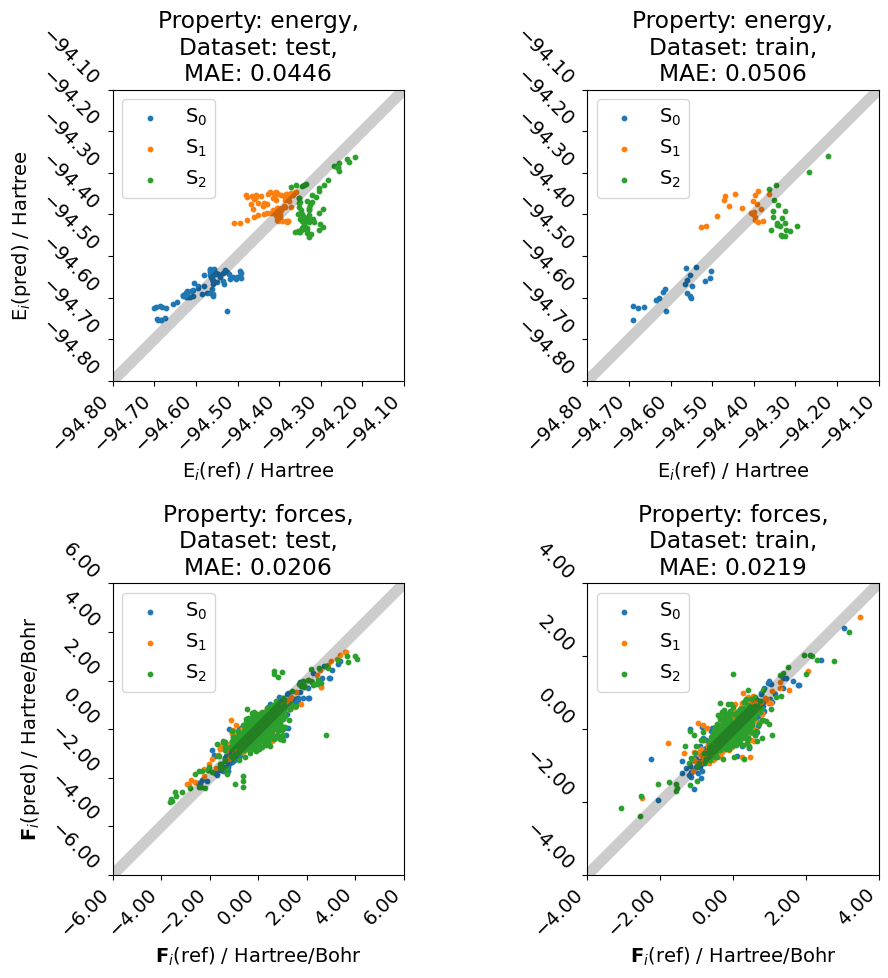

In [11]:
import spainn.plotting as sp

plotter = sp.PlotMAE(
    database = datapath,
    split_file = os.path.join(os.getcwd(), 'train', 'split.npz'),
    model_file = os.path.join(os.getcwd(), 'train', 'best_model_E_F'),
    cutoff = cutoff,
    properties2plot=['energy', 'forces'],
    subset2plot=['test', 'train'],
)

plotter.plot()